# Flight Price Prediction

In [1]:
#gerekli kutuphanelerin projeye dahil edilmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
train_data=pd.read_excel(r"data/Data_Train.xlsx") #excel'deki verinin okunması

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
train_data.shape

(10683, 11)

In [6]:
train_data["Duration"].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: Duration, Length: 368, dtype: int64

In [7]:
train_data.dropna(inplace=True)

In [8]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

# EDA

Date_of_Journey alanı object türünde verilerden oluştuğu için bu sütunu dogru bir sekilde kullanabilmek icin timestamp'e donusturmeliyiz

In [9]:
train_data["Date_of_Journey"].info()

<class 'pandas.core.series.Series'>
Int64Index: 10682 entries, 0 to 10682
Series name: Date_of_Journey
Non-Null Count  Dtype 
--------------  ----- 
10682 non-null  object
dtypes: object(1)
memory usage: 166.9+ KB


In [10]:
train_data["Journey_day"]=pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day

In [11]:
train_data["Journey_month"]=pd.to_datetime(train_data["Date_of_Journey"], format="%d/%m/%Y").dt.month

In [12]:
#olusturulan yolculuk ay ve gun tarihleri icin sutunlarini goruntuleyebiliriz
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [13]:
#Date_of_Journey sutununu kullanabilecegimiz sutunlara donusturduk. Artik bu sutunu kullanmayacagimiz icin silebiliriz
train_data.drop(["Date_of_Journey"], axis=1, inplace=True)

In [14]:
#Ucagin kalkis saati olan Departure Time(Dep_Time) sutunundan da saat ve dakika gibi verileri secebiliriz

train_data["Dep_hour"]=pd.to_datetime(train_data["Dep_Time"]).dt.hour
train_data["Dep_min"]=pd.to_datetime(train_data["Dep_Time"]).dt.minute
train_data.drop(["Dep_Time"], axis=1, inplace=True)

In [15]:
train_data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [16]:
#Ucagin varis saati olan Arrival Time(Arrival_Time) sutunundan da bu extract(secme) islemlerini gerceklestirebiliriz
#Varis zamaninda yer alan ay bilgisi gereksizdir. Bunun icin Date_of_Journey'den Journey_month secme islemi gerceklestirdik.

train_data["Arrival_hour"]=pd.to_datetime(train_data.Arrival_Time).dt.hour
train_data["Arrival_min"]=pd.to_datetime(train_data.Arrival_Time).dt.minute
train_data.drop(["Arrival_Time"], axis=1, inplace=True)

In [17]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [18]:
#Duration ucagin varis noktasina ulasmasi icin gecen suredir. Departure Time ile Arrival Time arasindaki farktir

#Duration sutununu donusturme ve listeye atama islemleri
#Bazi surelerde sadece saat bulunurken bazilarinda sadece dakika olabilir. Bunlarin hepsini belirli bir formata getirelim "0h 55m" gibi
duration=list(train_data["Duration"])
for i in range(len(duration)):
    #Surenin sadece saat ya da dakikadan olusup olusmadigini kontrol edelim. Liste elemanlari 2'ye esitse sorun yoktur degilse istenilen formata getirelim
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i]=duration[i].strip()+" 0m"
        else:
            duration[i]="0h "+duration[i]
            
#Saat ve dakika icin listeleri olusturma
duration_hours=[]
duration_mins=[]
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep="h")[0])) #Durationdan saatleri secmek
    duration_mins.append(int(duration[i].split(sep="m")[0].split()[-1])) #Durationdan dakikalari secmek
    

In [19]:
# Egitim veri setine saat ve dakika surelerini(duration_hours,duration_mins) ekleme
train_data["Duration_hours"]=duration_hours
train_data["Duration_mins"]=duration_mins

train_data.drop(["Duration"], axis=1, inplace=True)

In [20]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


# Kategorik Veriler

In [21]:
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

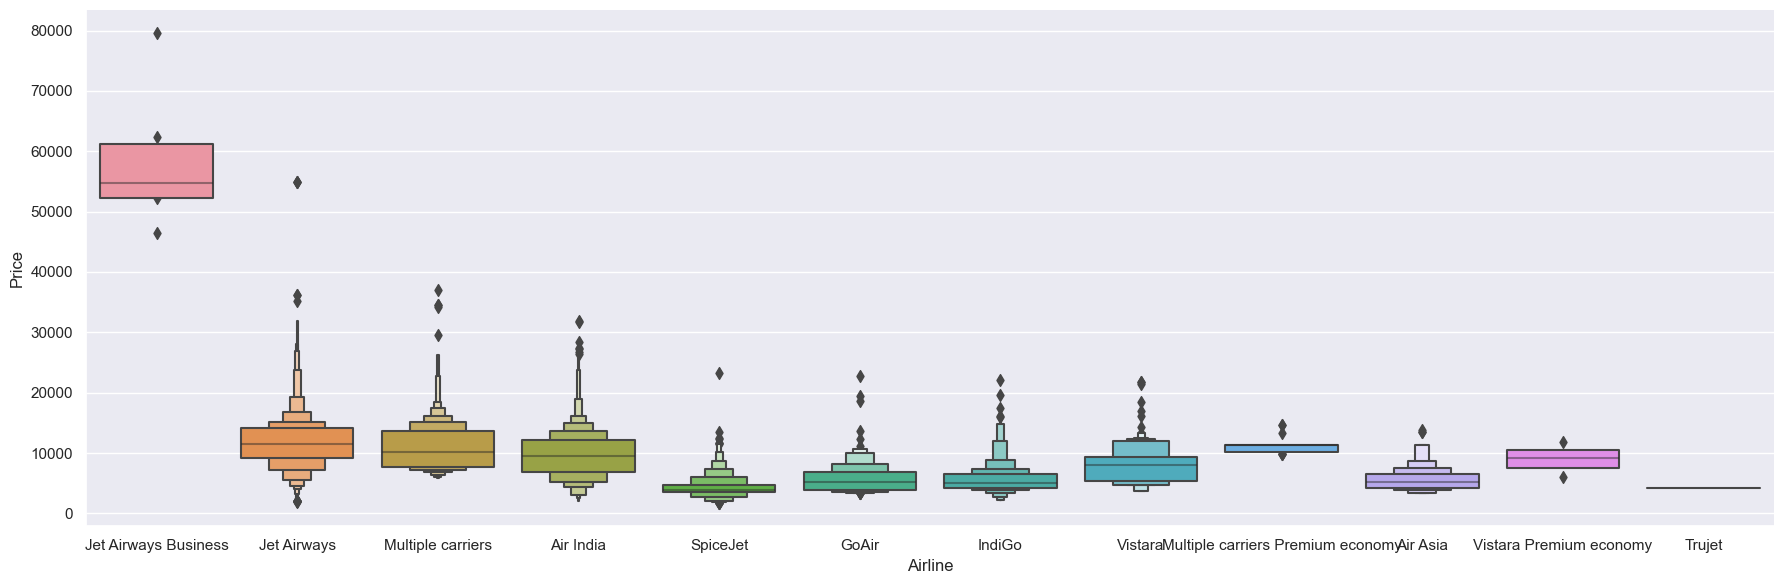

In [22]:
# Havayollari ve fiyatlari gormek icin bir grafik goruntuleyelim
sns.catplot(y="Price",x="Airline",data=train_data.sort_values("Price",ascending=False), kind="boxen",height=6,aspect=3)
plt.show()

Grafikten Jet Airways Business'ın en yüksek fiyata sahip olduğunu görebiliriz. Jet Airways Business dışında hemen hepsi benzer medyanlara sahip

Airlines kategorisini Havayolu şirketleri nominal veriler oldugundan OneHotEncoder uygulayabiliriz

In [23]:
#OneHotEncoder
Airline=train_data[["Airline"]]
Airline=pd.get_dummies(Airline,drop_first=True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [24]:
train_data["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

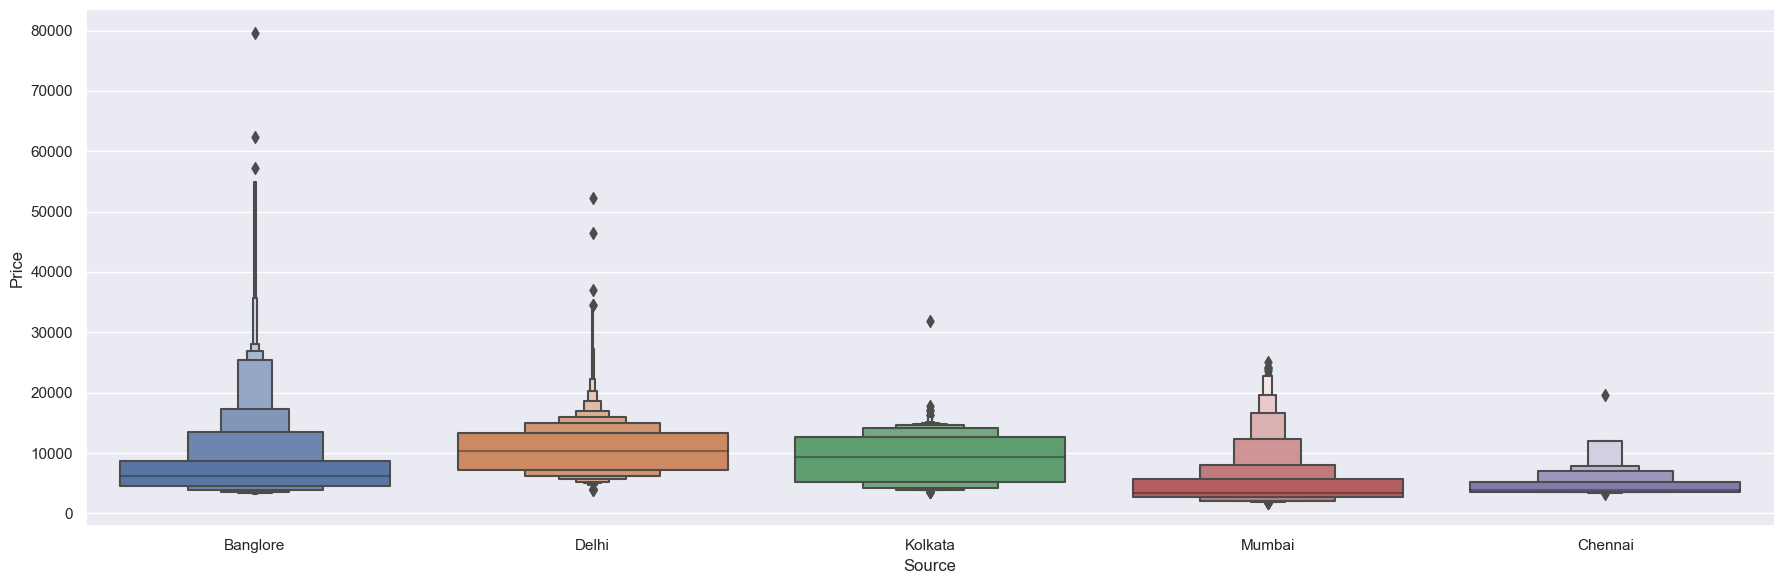

In [25]:
#Source, Price grafigi
sns.catplot(y="Price",x="Source",data=train_data.sort_values("Price",ascending=False), kind="boxen",height=6,aspect=3)
plt.show()

In [26]:
# Source yine nominal kategorik veri oldugu icin OneHotEncoding yapilabilir.
Source=train_data[["Source"]]
Source=pd.get_dummies(Source,drop_first=True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [27]:
train_data["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [28]:
# Destination yine nominal kategorik veri oldugu icin OneHotEncoding yapilabilir.
Destination=train_data[["Destination"]]
Destination=pd.get_dummies(Destination,drop_first=True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [29]:
#Additional_Info daha cok no_info bilgisinden olusuyor ve modeli etkilemeyecegi ongorulebiliyor. Route kolonu ise Total_Stops kolonuyla iliskili
#Additional_Info ve Route kolonunu veri setimizden cikaralim

train_data.drop(["Route","Additional_Info"],axis=1,inplace=True)

In [30]:
train_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

Toplam Durak sayıları ordinal veriler oldugundan LabelEncoder uygulanabilir

In [31]:
train_data.replace({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


In [32]:
#Olusturulan dataframeleri train data icin birlestirmek
data_train=pd.concat([train_data,Airline,Source,Destination],axis=1)

In [33]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [34]:
#Encode edilip yeni sutunlara ayrilmis Airline,Source,Destination alanlarini silelim
data_train.drop(["Airline","Source","Destination"],axis=1,inplace=True)

In [35]:
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
data_train.shape

(10682, 30)

# Test Veri Seti

In [37]:
test_data=pd.read_excel(r"data/Test_set.xlsx")

In [38]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [39]:
print(test_data.info())
print("-----------"*4)
test_data.dropna(inplace=True)
print("Null Values: \n",test_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None
--------------------------------------------
Null Values: 
 Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64


#### Bu veri seti için de EDA ve Kategorik veri işlemlerini uygulamalıyız. Veriseti bölünmeden aynı işlemlerden geçip en sonda da train ve test veri seti olarak ayrılabilirdi. Ancak bu veri seti önceden ayrılmış bu şekilde de uygulanabilir.

In [40]:
#EDA
#Date_of_Journey
test_data["Journey_day"]=pd.to_datetime(test_data.Date_of_Journey,format="%d/%m/%Y").dt.day
test_data["Journey_month"]=pd.to_datetime(test_data.Date_of_Journey,format="%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis=1, inplace=True)
#Dep_Time(Departure Time)
test_data["Dep_hour"]=pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"]=pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis=1, inplace=True)
#Arrival_Time
test_data["Arrival_hour"]=pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"]=pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis=1, inplace=True)

In [41]:
#Duration sutununu donusturme ve listeye atama islemleri
#Bazi surelerde sadece saat bulunurken bazilarinda sadece dakika olabilir. Bunlarin hepsini belirli bir formata getirelim "0h 55m" gibi
duration=list(test_data["Duration"])
for i in range(len(duration)):
    #Surenin sadece saat ya da dakikadan olusup olusmadigini kontrol edelim. Liste elemanlari 2'ye esitse sorun yoktur degilse istenilen formata getirelim
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i]=duration[i].strip()+" 0m"
        else:
            duration[i]="0h "+duration[i]    
#Saat ve dakika icin listeleri olusturma
duration_hours=[]
duration_mins=[]
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep="h")[0])) #Durationdan saatleri secmek
    duration_mins.append(int(duration[i].split(sep="m")[0].split()[-1])) #Durationdan dakikalari secmek

# Test veri setine saat ve dakika surelerini(duration_hours,duration_mins) ekleme
test_data["Duration_hours"]=duration_hours
test_data["Duration_mins"]=duration_mins
test_data.drop(["Duration"], axis=1, inplace=True)

In [42]:
#Kategorik Veriler
#Airline
Airline=test_data[["Airline"]]
Airline=pd.get_dummies(Airline,drop_first=True)
#Source
Source=test_data[["Source"]]
Source=pd.get_dummies(Source,drop_first=True)
#Destination
Destination=test_data[["Destination"]]
Destination=pd.get_dummies(Destination,drop_first=True)
#Total_Stops
test_data.replace({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4},inplace=True)
#Additional_Info ve Route kolonunu test setimizden cikaralim
test_data.drop(["Route","Additional_Info"],axis=1,inplace=True)
#Olusturulan dataframe'leri birlestirelim
data_test=pd.concat([test_data,Airline,Source,Destination],axis=1)
#Encode edilip yeni sutunlara ayrilmis Airline,Source,Destination alanlarini silelim
data_test.drop(["Airline","Source","Destination"],axis=1,inplace=True)

In [43]:
data_test.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,6,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# Özelliklerin Seçimi(Feature Selection)

Hedef değişkenimizle en iyi ilişkiye sahip özelliklerin çıkarımı

In [44]:
data_train.shape

(10682, 30)

In [45]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [46]:
X=data_train.loc[:,['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [47]:
# y degeri price kolonundan olusur
y=data_train.iloc[:,1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

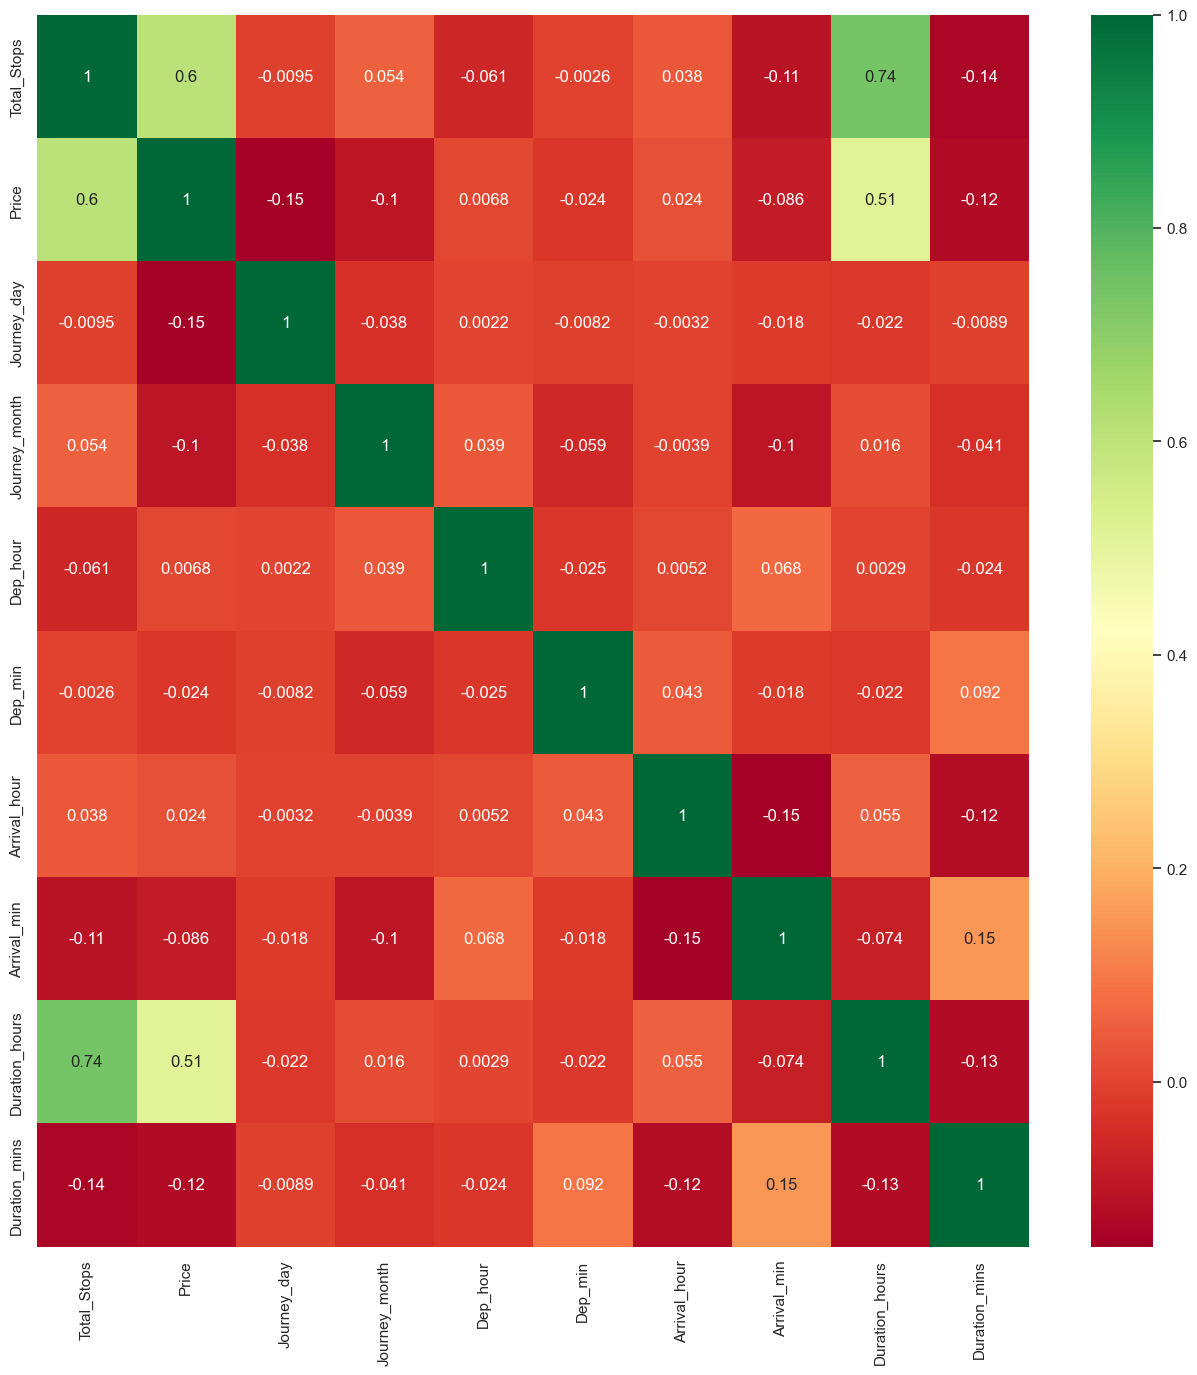

In [48]:
# Bagimli degisken ve bagimsiz degiskenler arasindaki iliskiyi inceleyelim
plt.figure(figsize=(16,16))
sns.heatmap(train_data.corr(),annot=True,cmap="RdYlGn")
plt.show()

In [49]:
# Ozellikler icin ExtraRegressor kullanimi

from sklearn.ensemble import ExtraTreesRegressor
selection=ExtraTreesRegressor()
selection.fit(X,y)

ExtraTreesRegressor()

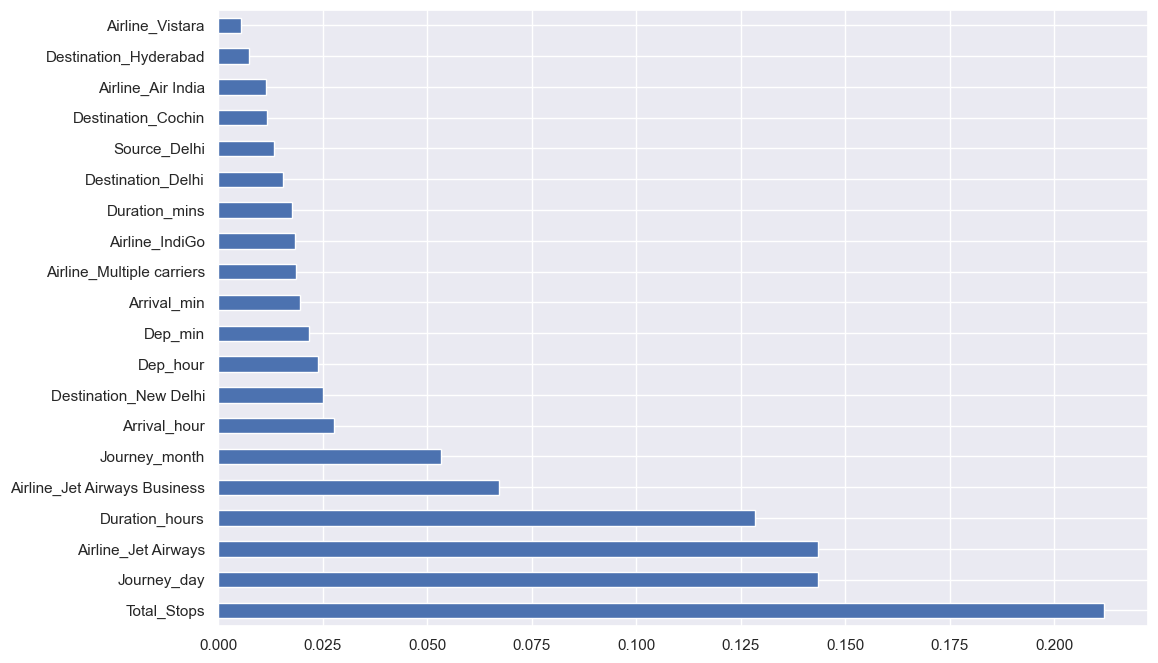

In [50]:
# Ozelliklerin onem degerlerinin gorsellestirilmesi

plt.figure(figsize=(12,8))
feat_importances=pd.Series(selection.feature_importances_,index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Model Eğitimi(Random Forest ile)

In [51]:
#Egitim ve test verisini bolme
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [52]:
#Modeli egitme
from sklearn.ensemble import RandomForestRegressor
reg_rf=RandomForestRegressor()
reg_rf.fit(X_train,y_train) #Egitim verileriyle modeli olusturmak

RandomForestRegressor()

In [53]:
y_pred=reg_rf.predict(X_test) #Test degiskenleriyle tahmin

In [54]:
reg_rf.score(X_train,y_train)

0.9551950198046091

In [55]:
reg_rf.score(X_test,y_test) #Modelin basari orani

0.813762845031081

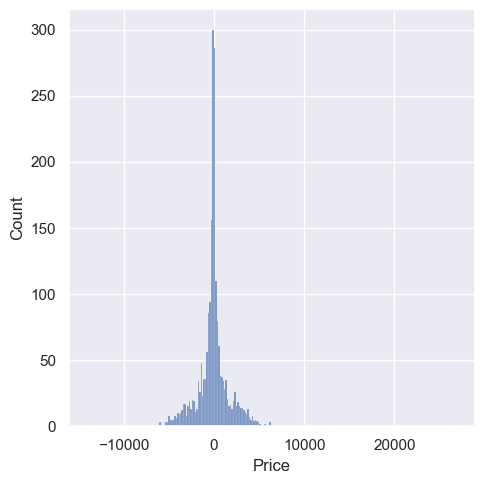

In [56]:
sns.displot(y_test-y_pred)
plt.show()

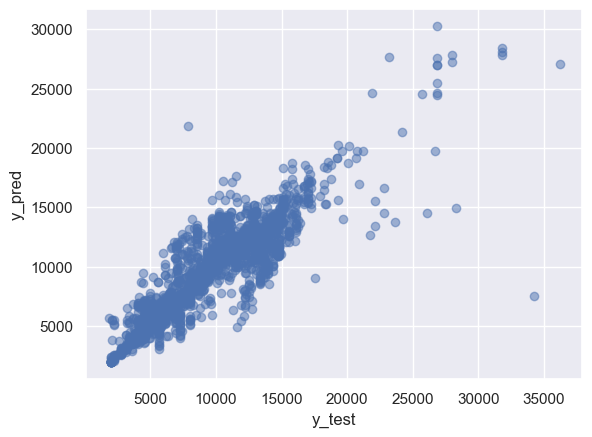

In [57]:
plt.scatter(y_test,y_pred,alpha=0.5)
plt.xlabel("y_test"),plt.ylabel("y_pred")
plt.show()

# Model Doğruluğunu Ölçmek 

In [58]:
from sklearn import metrics

In [59]:
print('MAE: ',metrics.mean_absolute_error(y_test,y_pred))
print('MSE: ',metrics.mean_squared_error(y_test,y_pred))
print('RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE:  1158.3219234790063
MSE:  3737031.3571620495
RMSE:  1933.1402838806214


In [60]:
metrics.r2_score(y_test,y_pred)

0.813762845031081

# Hiperparametre Ayarlama (Hyperparameter Tuning)

In [61]:
#RandomizedSearchCV 'yi dahil etmek
from sklearn.model_selection import RandomizedSearchCV

In [62]:
#Randomized Search CV

#Random Forest'teki agac sayisi
n_estimators=[int(x) for x in np.linspace(start=100,stop=1200,num=12)]
#Her bölmede dikkate alınması gereken özellik sayısı
max_features=['auto','sqrt']
#Agactaki maksimum duzey sayisi
max_depth=[int(x) for x in np.linspace(5,30,num=6)]
#Bir dugumu bolmek icin gereken minimum ornek sayisi
min_samples_split=[2,5,10,15,100]
#Her bir yaprak dugumde olmasi gereken minimum ornek sayisi
min_samples_leaf=[1,2,5,10]

#random grid'i olusturmak
random_grid={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf}

In [63]:
#5 Katlı Cross-Validation kullanarak parametrelerin rastgele aranması
rf_random=RandomizedSearchCV(estimator=reg_rf,param_distributions=random_grid,scoring='neg_mean_squared_error',n_iter=10,cv=5,verbose=2,random_state=42,n_jobs=1)

In [64]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   4.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   4.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [65]:
# En iyi parametreler
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [66]:
prediction=rf_random.predict(X_test)

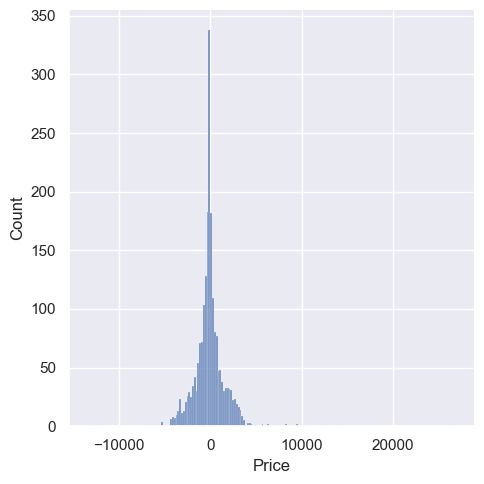

In [67]:
sns.displot(y_test-prediction)
plt.show()

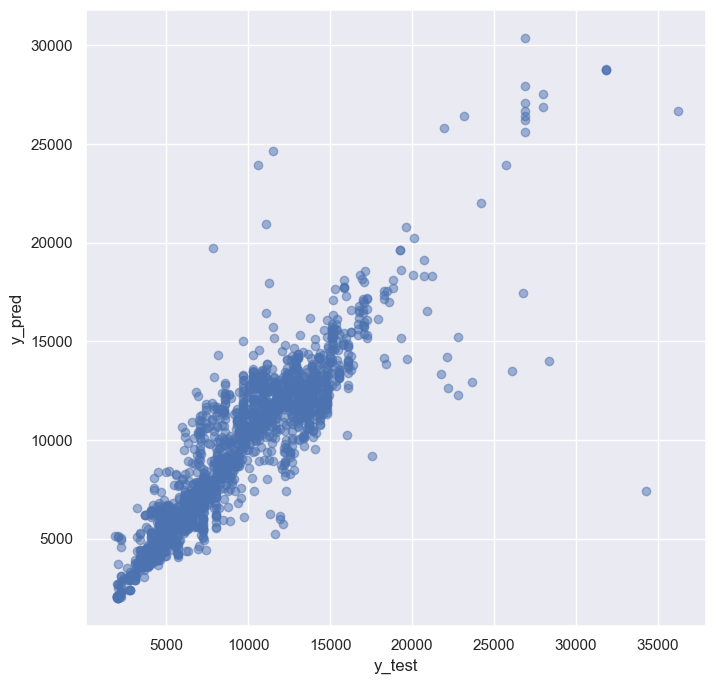

In [68]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,prediction,alpha=0.5)
plt.xlabel("y_test"),plt.ylabel("y_pred")
plt.show()

In [69]:
print('MAE: ',metrics.mean_absolute_error(y_test,prediction))
print('MSE: ',metrics.mean_squared_error(y_test,prediction))
print('RMSE: ',np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE:  1116.1902315170955
MSE:  3380020.9655385315
RMSE:  1838.4833329509765


## Tekrar Kullanmak için Modeli Kaydedelim

In [70]:
import pickle
# verileri depolayacagimiz bir dosya acalim
file=open('flight_price_rf.pkl','wb')
# bilgileri dosyaya kaydedelim
pickle.dump(rf_random,file)

In [71]:
model=open('flight_price_rf.pkl','rb')
forest=pickle.load(model)

In [72]:
y_prediction=forest.predict(X_test)

In [73]:
metrics.r2_score(y_test,y_prediction)

0.8315546678111809